In [1]:
%matplotlib inline
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import gammaln

from itertools import permutations

import os

In [2]:
from py4j.java_gateway import JavaGateway
import subprocess
import time

import sys

In [3]:
from volatility_detector import VolatilityDetector

In [4]:
import scaw2 as SCAW2

In [5]:
from smdl import SMDL
from model import Bernoulli

In [6]:
import tqdm

In [7]:
outdir = '../output/experiment1'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [8]:
np.random.seed(123)

In [9]:
#cmd
beta = 0.05
#detector = 
delta = 0.05
blockSize = 32
epsilon_prime = 0.0075
#alpha = 0.6
alpha = 0.6
decaymode = 1
compression_term = 75

In [10]:
class_path = './ICDMFiles_SEED_py4j/'
sys.path.insert(0, class_path)

java_file = 'SEEDChangeDetector'
class_path = '-cp ' + class_path
cmd = "java {0} {1} {2} {3} {4} {5} {6}".format(
            class_path, java_file, 
            delta, blockSize, epsilon_prime,
            alpha, compression_term)

In [11]:
cmd

'java -cp ./ICDMFiles_SEED_py4j/ SEEDChangeDetector 0.05 32 0.0075 0.6 75'

In [12]:
p = subprocess.Popen(cmd, shell=True)
time.sleep(3)
gateway = JavaGateway(start_callback_server=True)

In [13]:
detector_app = gateway.entry_point

## evaluate benefit and false alarm rate

In [14]:
def experiment1_benefit_false_alarm_rate(
         length1, length2, cmd, detector,
         r=0.5,
         delta=0.05, blocksize=32, epsilon_prime=0.0075,
         alpha=0.6, decaymode=1, compression_term=75,
         B=32, R=32, 
         mu1=0.2, mu2=0.8,
         n_repeat=50, n_trial=100,
         #beta_list=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 
         limit=5
):
    # volatility detector
    benefits_vd, fars_vd = [], []   # benefit, false alarm rate
    
    # metachange detector
    benefits_md, fars_md = [], []  # benefit, false alarm rate
    
    for i in tqdm.tqdm(range(n_trial)):
        seed = i
        # change detection with SEED
        change_points = detector_app.expr_volshift(
            mu1, mu2, length1, length2, n_repeat, seed)
        change_points_npa = np.array(list(change_points))
        change_points_npa_diff = np.diff(change_points_npa)
        cps = change_points_npa[1:]

        # metachange detector
        lambdas_hat = np.array(
                [(1 - (1-r)**(i+1)) / \
                 (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_npa_diff[:i+1] )) \
                 for i in range(len(change_points_npa_diff))]
        )
        codelen = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_npa_diff[1:]
        #codelen = -np.log(lambdas_hat) + lambdas_hat * change_points_npa_diff
        change_rate_codelen = np.diff(codelen)/codelen[:-1]
        change_rate_codelen_bwd = np.diff(codelen)/codelen[1:]
        
        benefits_vd_i, fars_vd_i = [], []
        benefits_md_i, fars_md_i = [], []

        # volatility detector
        #for thr in np.arange(0.0, 0.991, 0.001):
        #    try:
        #vdetector = VolatilityDetector(beta=thr, seed=i)
        vdetector = VolatilityDetector(b=B, r=R, seed=i)
        #res_vd = [vdetector.detect(change_points_npa_diff[i]) for i in range(len(change_points_npa_diff))]
        relvol = np.array([vdetector.detect(change_points_npa_diff[i]) for i in range(len(change_points_npa_diff))])
        bnd_list = np.sort(np.abs(relvol[~np.isnan(relvol)] - 1.0))
        for bnd in bnd_list:
            #is_metachange = np.array([r[0] for r in res_vd])
            #relvol = np.array([r[1] for r in res_vd])
            #is_metachange = np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd)
            is_metachange = np.logical_or(relvol > 1.0 + bnd, relvol < 1.0 - bnd)
            
            idxes_over_thr = np.where(
                np.logical_and(
                    #np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                    np.logical_or(relvol > 1.0 + bnd, relvol < 1.0 - bnd),
                    ~np.isnan(relvol)
                )
            )[0]
            cps_over_thr = cps[idxes_over_thr]
            within_tol_interval = np.logical_and(
                                    cps_over_thr - 2*n_repeat*length1 - blocksize >= 0,
                                    cps_over_thr - 2*n_repeat*length1 <= limit*length2)
            
            #within_tol_interval = np.logical_or((cps_over_thr - 2*n_repeat*length1) >= 0, 
            #                                                             (cps_over_thr - 2*n_repeat*length1) <= limit * length2)
            # benefit
            benefit = 0.0
            if np.any(within_tol_interval):
                dist_from_cp = np.abs(cps_over_thr[within_tol_interval] - 2*n_repeat*length1)
                #idx = np.argmin(dist_from_cp)
                #if dist_from_cp[idx] <= limit*length2:
                    #benefit = 1 - np.abs(cps_over_thr[idx] - 2*n_repeat*length1)/(limit*length2)
                    #benefit = 1 - dist_from_cp[idx]/(limit*length2)
                    
                #benefit = np.sum(1 - (dist_from_cp/(limit*length2)))
                benefit = 1 - (dist_from_cp[0]/(limit*length2))
                #else:
                #    benefit = 0.0
            #else:
            #    benefit = 0.0
            benefits_vd_i.append(benefit)
                
            n_alarm = np.sum(np.logical_and(
                #np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                np.logical_or(relvol > 1.0 + bnd, relvol < 1.0 - bnd),
                ~np.isnan(relvol)
            ))
            # false alarm
            n_fp = np.sum(
                np.logical_and(
                    np.logical_and(
                         #np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                         np.logical_or(relvol > 1.0 + bnd, relvol < 1.0 - bnd),
                        ~np.isnan(relvol)
                    ),
                    np.logical_or(
                        #cps <= 2*n_repeat*length1 - limit*length2, 
                        cps <= 2*n_repeat*length1, 
                        cps >= 2*n_repeat*length1 + limit*length2
                    )
                )
            )
            #fars_vd_i.append(far)
            #fars_vd_i.append(n_fp/n_alarm)
            fars_vd_i.append(n_fp)

            #except:
            #    break
        
        benefits_vd.append(np.array(benefits_vd_i))   # benefit
        fars_vd.append(np.array(fars_vd_i))  # false alarm rate
        
        #maxvalue = np.max(np.abs(change_rate_codelen[change_points_npa[3:] >= 2*length1*n_repeat + blockSize]))
        thr_list = np.sort(np.abs(change_rate_codelen[B+R-3:]))
        #for thr in np.arange(0.0, maxvalue + 0.0001, 0.0001):
        for thr in thr_list:
            # metachange detector
            # benefit
            #idx_over_thr_after_cp = np.where(np.logical_and(change_points_npa[3:] >= 2*length1*n_repeat + blockSize,
            #                            np.abs(change_rate_codelen) >= thr))[0]
            
            #idx_over_thr_after_cp = np.where(np.logical_and(
            #                            change_points_npa[B+R:] >= 2*length1*n_repeat + blockSize,
            #                            np.abs(change_rate_codelen[B+R-3:]) >= thr))[0]
            idxes_over_thr_after_cp_within = np.where(
                                            np.logical_and(
                                                np.logical_and(
                                                    change_points_npa[B+R:] >= 2*length1*n_repeat + blockSize,
                                                    change_points_npa[B+R:] <= 2*length1*n_repeat + limit*length2
                                                ),
                                                np.logical_or(
                                                    #np.abs(change_rate_codelen[B+R-3:]) >= thr
                                                    np.abs(change_rate_codelen[B+R-3:]) > thr, 
                                                    np.abs(change_rate_codelen_bwd[B+R-3:]) > thr
                                                )
                                            ))[0]
            #if len(idx_over_thr_after_cp) == 0:
            #    break
            #if len(idx_over_thr_after_cp) == 0:
            #    benefit = 0.0
            if len(idxes_over_thr_after_cp_within) == 0:
                benefit = 0.0
            else :
                #idx_first = idx_over_thr_after_cp[0] + B+R
                #idx_first = idxes_over_thr_after_cp_within[0] + B+R
                #benefit = np.max([0, 1- (change_points_npa[idx_first] - 2*length1*n_repeat)/(limit * length2)])
                #benefit = np.sum(1 - (change_points_npa[B+R+idxes_over_thr_after_cp_within] - 2*length1*n_repeat) / (limit * length2))
                benefit = np.sum(1 - (change_points_npa[B+R+idxes_over_thr_after_cp_within][0] - 2*length1*n_repeat) / (limit * length2))
    
            #idx_first = np.where(np.logical_and(change_points_npa[3:] >= 2*length1*n_repeat + blockSize,
            #                            np.abs(change_rate_codelen) >= thr))[0][0] + 3
            
            # false positive rate
            #n_alarm = np.sum(np.abs(change_rate_codelen[B+R-3:]) >= thr)
            n_alarm = np.sum(np.abs(change_rate_codelen[B+R-3:]) > thr)
            #if n_alarm == 0:
            #    break
            n_fp = np.sum(
                    np.logical_and(
                        np.logical_or(
                            #change_points_npa[3:] >= 2*length1*n_repeat + blockSize + limit*length2, 
                            #change_points_npa[3:] < 2*length1*n_repeat + blockSize
                            change_points_npa[B+R:] >= 2*length1*n_repeat + limit*length2, 
                            change_points_npa[B+R:] < 2*length1*n_repeat
                        ), 
                        np.logical_and(
                            #np.abs(change_rate_codelen) >= thr
                            #np.abs(change_rate_codelen[B+R-3:]) >= thr,
                            np.abs(change_rate_codelen[B+R-3:]) > thr,
                            ~np.isnan(change_rate_codelen[B+R-3:])
                        )
                    )
                 )

            benefits_md_i.append(benefit)
            #fars_md_i.append(n_fp/n_alarm)
            fars_md_i.append(n_fp)

        benefits_md.append(np.array(benefits_md_i))
        fars_md.append(np.array(fars_md_i))

    #return np.array(benefits_vd), np.array(fars_vd), np.array(benefits_md), np.array(fars_md)
    return benefits_vd, fars_vd, benefits_md, fars_md

In [15]:
def calc_auc(fars, benefits):
    # sort by ascending order
    #idx_ordered = np.argsort(fars)
    idx_ordered = np.lexsort((fars, benefits))
    fars_ordered = fars[idx_ordered]
    benefits_ordered = benefits[idx_ordered]
    #if abs(fars_ordered[0]) > 1e-6:
    #if fars_ordered[0] != 0.0:
    if np.abs(fars_ordered[0]) > 1e-6:
        #fars_ordered = np.hstack((0, 0, fars_ordered))
        fars_ordered = np.hstack((0, 0, fars_ordered))
        #benefits_ordered = np.hstack((0, benefits_ordered[0], benefits_ordered))
        #fars_ordered = np.hstack((0, fars_ordered[0], fars_ordered))
        #benefits_ordered = np.hstack((0, 0, benefits_ordered))
        benefits_ordered = np.hstack((0, benefits_ordered[0], benefits_ordered))
        #fars_ordered = np.hstack((0, fars_ordered))
        #benefits_ordered = np.hstack((0, benefits_ordered))
    elif benefits_ordered[0] != 0.0:
        fars_ordered = np.hstack((0, fars_ordered))
        benefits_ordered = np.hstack((0, benefits_ordered))

    # calculate AUC
    #auc = np.abs(np.sum(np.diff(fars_ordered/np.max(fars_ordered)) * 
    #                       np.abs(benefits_ordered[:-1])/np.max(np.abs(benefits_ordered[:-1])))
    # )
    if np.all(benefits_ordered == 0):
        auc = 0.0
    else:
        #auc = np.trapz(benefits_ordered/np.max(benefits_ordered),
        #           fars_ordered/np.max(fars_ordered))
        auc = np.trapz(benefits_ordered,
                       fars_ordered/np.max(fars_ordered))
    return auc

# dependency on B and R

In [16]:
# Dependency on B
df_all = []
r = 0.2
for (length1, length2) in permutations([500, 1000, 5000, 10000, 50000, 100000], 2):
    for B in [8, 16, 24, 32, 40]:
        benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate(
            length1, length2, cmd, detector_app,
            r=r, 
            delta=0.05, blocksize=32, epsilon_prime=0.0075,
            alpha=0.6, decaymode=1, compression_term=75,
            mu1=0.2, mu2=0.8,
            B=B, R=B, 
            n_repeat=50, 
            n_trial=50, 
            limit=5
        )
    
        # AUC (vd)
        auc_vd = []
        for far, benefit in zip(fars_vd, benefits_vd):
            auc_vd.append(calc_auc(far, benefit))

        df = pd.DataFrame({'L1': length1, 
                      'L2': length2, 
                      'B': B,
                      'AUC': auc_vd})
        df_all.append(df)

df_all_dep_B = pd.concat(df_all)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/sfukushima/Documents/phd/theme/myself/MetaChangeDetection/paper/entropy/2019/revised/src/volatility_detector.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  relative_variance = var_buffer / var_reservoir
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:88: Run

/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 576x288 with 0 Axes>

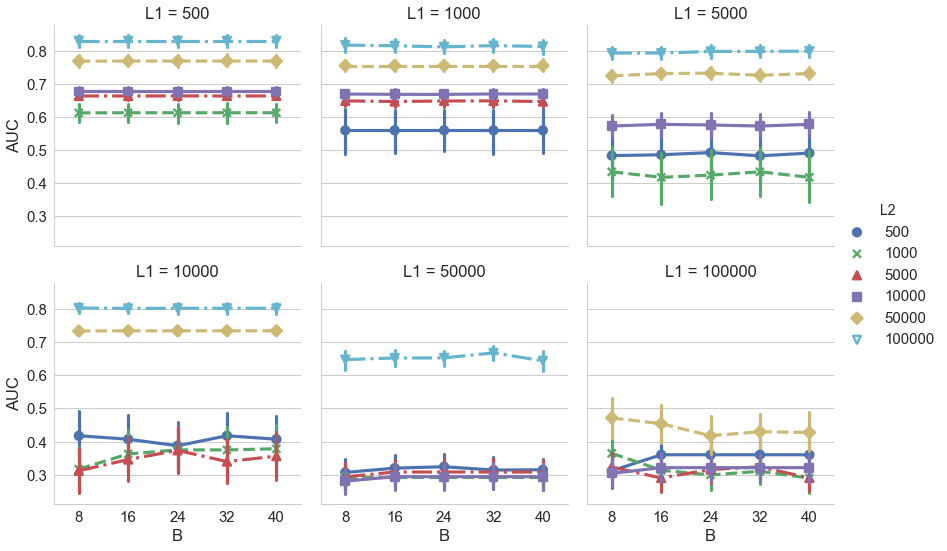

In [17]:
import seaborn as sns
sns.reset_orig()

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.factorplot(x='B', y='AUC', col='L1', 
               hue='L2', col_wrap=3, 
               markers=['o', 'x', '^', 's', 'D', 'v'], 
               linestyles=['-', '--', '-.', '-', '--', '-.'], 
               data=df_all_dep_B)
plt.savefig(os.path.join(outidr, 'dependency_on_B_vd.eps'), dpi=200)

# dependency on change detection parameters

In [17]:
# Dependency on r
df_all_dep_B_vd = []
for (length1, length2) in permutations([500, 1000, 5000, 10000, 50000, 100000], 2):
    for alpha in [0.2, 0.4, 0.6, 0.8]:
        benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate(
                length1, length2, cmd, detector_app,
                r=0.2, 
                delta=0.05, blocksize=32, epsilon_prime=0.0075,
                alpha=alpha, decaymode=1, compression_term=75,
                mu1=0.2, mu2=0.8,
                n_repeat=50, 
                n_trial=20, 
                limit=5
            )
    
        # AUC (vd)
        auc_vd = []
        for far, benefit in zip(fars_vd, benefits_vd):
            auc_vd.append(calc_auc(far, benefit))

        df = pd.DataFrame({'L1': length1, 
                      'L2': length2, 
                      'alpha': alpha, 
                      'AUC': auc_vd})
        df_all_dep_B_vd.append(df)

  0%|          | 0/20 [00:00<?, ?it/s]


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:25333)

In [17]:
df_all_concat_alpha = pd.concat(df_all)

NameError: name 'df_all' is not defined

In [25]:
df_all_concat_alpha.head(3)

,AUC,L1,L2,alpha
0,0.291071,100000,50000,0.2
1,0.423151,100000,50000,0.2
2,0.656025,100000,50000,0.2


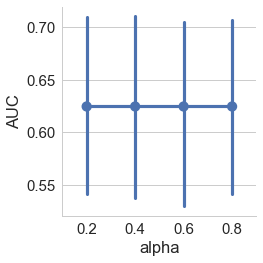

In [27]:
sns.reset_orig()

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.factorplot(x='epsilon_prime', y='AUC', col='L1', col_wrap=3, hue='L2', 
               markers=['o', 'x', '^', 's', 'D', 'v'], 
               linestyles=['-', '--', '-.', '-', '--', '-.'], 
               data=df_all_concat_alpha)
plt.savefig('../output/experiment1_final/dependency_auc_on_threshold.eps', dpi=300)

In [20]:
# Dependency on r
df_all_epsilon = []
for (length1, length2) in permutations([500, 1000, 5000, 10000, 50000, 100000], 2):
    for epsilon_prime in [0.0025, 0.005, 0.0075]:
        benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate(
                length1, length2, cmd, detector_app,
                r=0.2, 
                delta=0.05, blocksize=32, epsilon_prime=epsilon_prime,
                alpha=0.2, decaymode=1, compression_term=75,
                mu1=0.2, mu2=0.8,
                n_repeat=50, 
                n_trial=10, 
                limit=5
            )
    
        # AUC (md)
        auc_md = []
        for far, benefit in zip(fars_md, benefits_md):
            auc_md.append(calc_auc(far, benefit))

        df = pd.DataFrame({'L1': length1, 
                      'L2': length2, 
                      'epsilon_prime': epsilon_prime, 
                      'AUC': auc_md})
        df_all_epsilon.append(df)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in greater
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in less
/Users/sfukushima/.pyenv/vers

In [21]:
df_all_epsilon_concat = pd.concat(df_all_epsilon)

In [22]:
df_all_epsilon_concat.head(3)

,AUC,L1,L2,epsilon_prime
0,0.966368,500,1000,0.0025
1,0.795400,500,1000,0.0025
2,0.968055,500,1000,0.0025


/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 576x288 with 0 Axes>

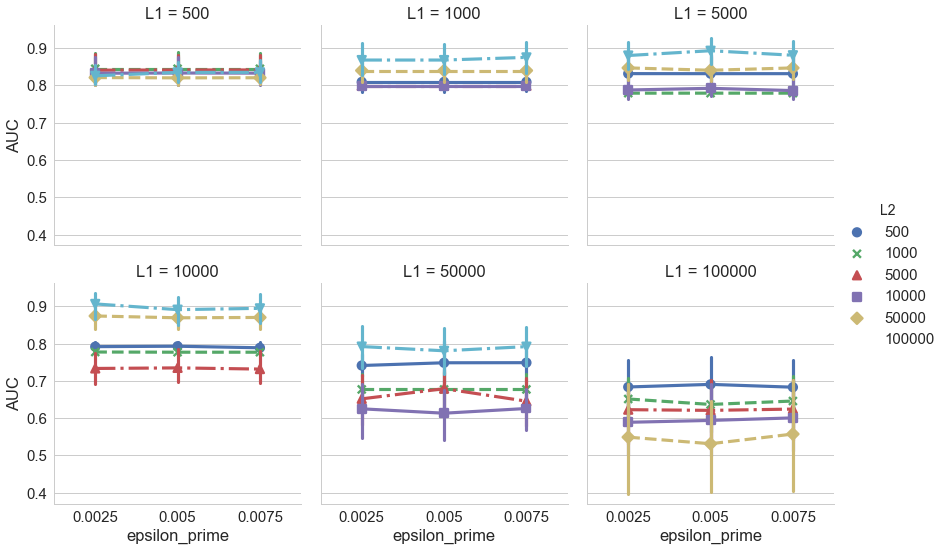

In [28]:
import seaborn as sns
sns.reset_orig()

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.factorplot(x='epsilon_prime', y='AUC', col='L1', 
               hue='L2', col_wrap=3, 
               markers=['o', 'x', '^', 's', 'D', 'v'], 
               linestyles=['-', '--', '-.', '-', '--', '-.'], 
               data=df_all_epsilon_concat)
plt.savefig('../output/experiment1_final/dependency_on_epsilon_prime.eps', dpi=200)

In [13]:
def detect_change_points_mdl(mdl_stats):
    mdl_stats = np.array(mdl_stats)
    idxes_stats_positive = np.where(mdl_stats > 0)[0]
    
    idxes_end = np.where(
                              np.diff(idxes_stats_positive) > 1
                          )[0]
    end = idxes_stats_positive[idxes_end]

    idxes_start = idxes_end + 1  
    if 0 not in idxes_start:
        idxes_start = np.hstack((0, idxes_start))

    start = idxes_stats_positive[idxes_start]

    if idxes_stats_positive[idxes_start[1]-1] not in end:
        end = np.hstack((idxes_stats_positive[idxes_start[1] - 1], end))
    if idxes_stats_positive[-1] not in end:
        end = np.hstack((end, idxes_stats_positive[-1]))

    change_points = []
    for s, e in zip(start, end):
        cp = s + np.argmax(mdl_stats[s:e+1])
        change_points.append(cp)

    change_points = np.array(change_points)
    return change_points

In [14]:
def experiment1_benefit_false_alarm_rate_smdl(
         length1, length2,
         r=0.5,
         B=32, R=32, 
         mu1=0.2, mu2=0.8,
         epsilon=1e-6, h=100,
         n_repeat=50, n_trial=100,
         blocksize=32, 
         #beta_list=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 
         limit=5
):
    # volatility detector
    benefits_vd, fars_vd = [], []   # benefit, false alarm rate
    
    # metachange detector
    benefits_md, fars_md = [], []  # benefit, false alarm rate
    
    for i in tqdm.tqdm(range(n_trial)):
        seed = i
        # generate data
        X_list = []
        for _ in range(n_repeat):
            X_list.append(
                np.random.binomial(1, mu1, length1)
            )
            X_list.append(
                np.random.binomial(1, mu2, length1)
            )
        for _ in range(n_repeat):
            X_list.append(
                np.random.binomial(1, mu1, length2)
            )
            X_list.append(
                np.random.binomial(1, mu2, length2)
            )
        X = np.hstack(X_list)
        T = len(X)
        # change detection with SEED
        #change_points = detector_app.expr_volshift(
        #    mu1, mu2, length1, length2, n_repeat, seed)
        smdl = SMDL(h, T, Bernoulli, 0.05)
        mdl_stats = [np.nan] * h + \
                      [smdl.calc_change_score(X[(i-h):(i+h)].ravel()) \
                        for i in range(h, T-h)] + \
                      [np.nan] * h
        mdl_stats = np.array(mdl_stats)
        #print(np.nanmin(mdl_stats - epsilon*T), np.nanmax(mdl_stats - epsilon*T))
        #change_points = detect_change_points_mdl(mdl_stats - epsilon*T)
        change_points = detect_change_points_mdl(mdl_stats - epsilon)
        print(change_points)
        #print(change_points)
        #change_points_npa = np.array(list(change_points))
        change_points_diff = np.diff(change_points)
        cps = change_points[1:]

        # metachange detector
        lambdas_hat = np.array(
                [(1 - (1-r)**(i+1)) / \
                 (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff[:i+1] )) \
                 for i in range(len(change_points_diff))]
        )
        codelen = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_diff[1:]
        change_rate_codelen = np.diff(codelen)/codelen[:-1]
        #print(change_rate_codelen)
        
        benefits_vd_i, fars_vd_i = [], []
        benefits_md_i, fars_md_i = [], []

        # volatility detector
        #for thr in np.arange(0.0, 0.991, 0.001):
        #    try:
        #vdetector = VolatilityDetector(beta=thr, seed=i)
        vdetector = VolatilityDetector(seed=i)
        #res_vd = [vdetector.detect(change_points_npa_diff[i]) for i in range(len(change_points_npa_diff))]
        relvol = np.array([vdetector.detect(change_points_diff[i]) for i in range(len(change_points_diff))])
        bnd_list = np.sort(np.abs(relvol[~np.isnan(relvol)] - 1.0))
        #for bnd in bnd_list:
        for bnd in np.linspace(bnd_list[0], bnd_list[-1], 100):
            #is_metachange = np.array([r[0] for r in res_vd])
            #relvol = np.array([r[1] for r in res_vd])
            is_metachange = np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd)
            
            idxes_over_thr = np.where(
                np.logical_and(
                    np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                    ~np.isnan(relvol)
                )
            )[0]
            cps_over_thr = cps[idxes_over_thr]
            within_tol_interval = (np.abs(cps_over_thr - 2*n_repeat*length1) <= limit*length2)
            #within_tol_interval = np.logical_or((cps_over_thr - 2*n_repeat*length1) >= 0, 
            #                                                             (cps_over_thr - 2*n_repeat*length1) <= limit * length2)
            # benefit
            benefit = 0.0
            if np.any(within_tol_interval):
                dist_from_cp = np.abs(cps_over_thr - 2*n_repeat*length1)
                idx = np.argmin(dist_from_cp)
                if dist_from_cp[idx] <= limit*length2:
                    benefit = 1 - np.abs(cps_over_thr[idx] - 2*n_repeat*length1)/(limit*length2)
                #else:
                #    benefit = 0.0        
            #else:
            #    benefit = 0.0
            benefits_vd_i.append(benefit)
                
            n_alarm = np.sum(np.logical_and(
                np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                ~np.isnan(relvol)
            ))
            # false alarm
            n_fp = np.sum(
                np.logical_and(
                    np.logical_and(
                        np.logical_or(relvol >= 1.0 + bnd, relvol <= 1.0 - bnd),
                        ~np.isnan(relvol)
                    ),
                    np.logical_or(
                        cps <= 2*n_repeat*length1 - limit*length2, 
                        cps >= 2*n_repeat*length1 + limit*length2
                    )
                )
            )
            #fars_vd_i.append(far)
            #fars_vd_i.append(n_fp/n_alarm)
            fars_vd_i.append(n_fp)

            #except:
            #    break
        
        benefits_vd.append(np.array(benefits_vd_i))   # benefit
        fars_vd.append(np.array(fars_vd_i))  # false alarm rate
        
        #maxvalue = np.max(np.abs(change_rate_codelen[change_points_npa[3:] >= 2*length1*n_repeat + blockSize]))
        thr_list = np.sort(np.abs(change_rate_codelen[B+R-3:]))
        #for thr in np.arange(0.0, maxvalue + 0.0001, 0.0001):
        #for thr in thr_list:
        for thr in np.linspace(thr_list[0], thr_list[-1], 100):
            # metachange detector
            # benefit
            #idx_over_thr_after_cp = np.where(np.logical_and(change_points_npa[3:] >= 2*length1*n_repeat + blockSize,
            #                            np.abs(change_rate_codelen) >= thr))[0]
            idx_over_thr_after_cp = np.where(np.logical_and(
                                        np.logical_and(
                                            change_points[B+R:] >= 2*length1*n_repeat + blocksize,
                                            change_points[B+R:] <= 2*length1*n_repeat + limit*length2
                                        ),
                                        np.abs(change_rate_codelen[B+R-3:]) >= thr))[0]
            #if len(idx_over_thr_after_cp) == 0:
            #    break
            if len(idx_over_thr_after_cp) == 0:
                benefit = 0.0
            else :
                idx_first = idx_over_thr_after_cp[0] + B+R
                benefit = np.max([0, 1- (change_points[idx_first] - 2*length1*n_repeat)/(limit * length2)])
                #benefit = np.sum(1 - (change_points[idx_over_thr_after_cp+B+R] - 2*length1*n_repeat)/(limit*length2))
                
            #idx_first = np.where(np.logical_and(change_points_npa[3:] >= 2*length1*n_repeat + blockSize,
            #                            np.abs(change_rate_codelen) >= thr))[0][0] + 3
            
            # false positive rate
            n_alarm = np.sum(np.abs(change_rate_codelen[B+R-3:]) >= thr)
            if n_alarm == 0:
                break
            n_fp = np.sum(
                    np.logical_and(
                        np.logical_or(
                            #change_points_npa[3:] >= 2*length1*n_repeat + blockSize + limit*length2, 
                            #change_points_npa[3:] < 2*length1*n_repeat + blockSize
                            change_points[B+R:] >= 2*length1*n_repeat + limit*length2, 
                            change_points[B+R:] < 2*length1*n_repeat
                        ), 
                        np.logical_and(
                            #np.abs(change_rate_codelen) >= thr
                            np.abs(change_rate_codelen[B+R-3:]) >= thr,
                            ~np.isnan(change_rate_codelen[B+R-3:])
                        )
                    )
                 )

            benefits_md_i.append(benefit)
            #fars_md_i.append(n_fp/n_alarm)
            fars_md_i.append(n_fp)
                
        benefits_md.append(np.array(benefits_md_i))
        fars_md.append(np.array(fars_md_i))

    #return np.array(benefits_vd), np.array(fars_vd), np.array(benefits_md), np.array(fars_md)
    return benefits_vd, fars_vd, benefits_md, fars_md

In [ ]:
for (length1, length2) in permutations([500, 1000, 5000], 2):
    benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate_smdl(
        length1, length2,
        r=0.2, 
        mu1=0.2, mu2=0.8,
        #epsilon=0.1/(2*50*(length1+length2)), h=100,
        #epsilon=1e-5, h=100,
        epsilon=1e-2, h=100, 
        n_repeat=50, n_trial=30,
        limit=5
    )
    #print(benefits_vd)
    #print(fars_vd)
    
    # AUC (vd)
    """
    fars_vd = fars_vd.ravel()
    benefits_vd = benefits_vd.ravel()
    auc_vd = calc_auc(fars_vd, benefits_vd)
    """
    auc_vd = []
    for far, benefit in zip(fars_vd, benefits_vd):
        auc_vd.append(calc_auc(far, benefit))
    
    # AUC (md)
    """"
    fars_md = fars_md.ravel()
    benefits_md = benefits_md.ravel()
    auc_md = calc_auc(fars_md, benefits_md)
    """
    auc_md = []
    for far, benefit in zip(fars_md, benefits_md):
        auc_md.append(calc_auc(far, benefit))
    
    print('length1=', length1, 'length2=', length2)
    print('  AUC(vd):', np.mean(auc_vd), '+/-', np.std(auc_vd))
    print('  AUC(md):', np.mean(auc_md), '+/-', np.std(auc_md))
    #print('  fars_vd:', fars_vd)
    #print('  benefits_vd:', benefits_vd)
    #print('  fars_md:', fars_md)
    #print('  benefits_md:', benefits_md)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


[   419    422    425 ... 149200 149295 149300]


/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater_equal
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less_equal
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater_equal
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less_equal
/Users/sfukushima/.pyenv/vers

[   168    187    271 ... 149630 149722 149845]


  7%|▋         | 2/30 [00:59<14:07, 30.27s/it]

[   193    238    241 ... 149495 149846 149866]


 10%|█         | 3/30 [01:32<14:03, 31.24s/it]

[   160    175    182 ... 149664 149769 149778]


 13%|█▎        | 4/30 [02:05<13:44, 31.70s/it]

[   300    304    307 ... 149658 149676 149764]


 17%|█▋        | 5/30 [02:35<13:02, 31.30s/it]

[   104    118    137 ... 148574 148997 149719]


 20%|██        | 6/30 [03:05<12:17, 30.74s/it]

[   497    836    924 ... 149619 149718 149896]


 23%|██▎       | 7/30 [03:36<11:50, 30.90s/it]

[   393    499    991 ... 149186 149205 149602]


 27%|██▋       | 8/30 [04:09<11:29, 31.36s/it]

[   365    379    496 ... 149767 149837 149877]


 30%|███       | 9/30 [04:41<11:05, 31.67s/it]

[   501    693    704 ... 149759 149768 149770]


 33%|███▎      | 10/30 [05:16<10:55, 32.77s/it]

[   162    424    502 ... 149706 149718 149868]


 37%|███▋      | 11/30 [05:44<09:53, 31.22s/it]

[   417    500    602 ... 149400 149459 149809]


 40%|████      | 12/30 [06:06<08:32, 28.47s/it]

[   504    577    580 ... 149336 149399 149436]


 43%|████▎     | 13/30 [06:26<07:21, 25.95s/it]

[   416    500    695 ... 149228 149277 149282]


 47%|████▋     | 14/30 [06:45<06:20, 23.81s/it]

[   337    341    348 ... 149316 149332 149683]


 50%|█████     | 15/30 [07:03<05:30, 22.06s/it]

[   417    501    737 ... 149205 149276 149302]


 53%|█████▎    | 16/30 [07:21<04:52, 20.90s/it]

[   163    174    228 ... 149890 149892 149898]


 57%|█████▋    | 17/30 [07:39<04:21, 20.13s/it]

[   187    255    260 ... 149596 149883 149885]


 60%|██████    | 18/30 [07:58<03:54, 19.57s/it]

[   288    368    386 ... 149603 149694 149703]


 63%|██████▎   | 19/30 [08:16<03:31, 19.19s/it]

[   380    422    500 ... 149655 149665 149822]


 67%|██████▋   | 20/30 [08:34<03:09, 18.91s/it]

[   412    501    991 ... 149000 149435 149535]


 70%|███████   | 21/30 [08:52<02:48, 18.73s/it]

[   503    603    787 ... 149676 149691 149696]


 73%|███████▎  | 22/30 [09:11<02:28, 18.55s/it]

[   101    113    493    918   1000   1500   1592   1594   2002   2081
   2086   2092   2156   2158   2163   2398   2495   2567   2999   3226
   3230   3326   3500   3690   3999   4147   4156   4181   4390   4416
   4502   4584   4864   4917   5000   5089   5501   6000   6287   6291
   6500   6690   6713   6725   6756   6916   7001   7126   7227   7500
   7655   7675   7710   7889   7920   8000   8101   8109   8501   8679
   8681   8685   8692   8999   9115   9150   9162   9335   9348   9354
   9405   9411   9493   9681   9691   9792  10000  10500  11000  11206
  11245  11368  11495  11835  12000  12409  12412  12414  12418  12500
  12930  13000  13256  13498  13655  13668  13671  14000  14102  14110
  14194  14206  14379  14415  14417  14421  14499  14573  14578  15001
  15500  15600  15615  15710  15812  15826  16000  16081  16304  16499
  16568  16920  17000  17086  17500  17883  17929  17995  18419  18498
  18645  18746  18773  18846  18897  19001  19172  19185  19195  19225
  1932

 77%|███████▋  | 23/30 [09:30<02:10, 18.67s/it]

[   218    422    497    925   1002   1278   1293   1315   1501   1739
   1780   1789   1793   1842   1878   1895   1905   2004   2307   2314
   2332   2430   2499   2577   2638   2859   2867   2871   2874   2999
   3064   3498   3869   3921   3984   4199   4506   4599   4699   4764
   4766   4999   5425   5506   5576   5813   5852   6000   6269   6372
   6503   7004   7498   7590   7608   7927   7929   8000   8090   8424
   8504   8598   8918   9000   9500  10000  10501  11003  11069  11406
  11509  11749  11917  11921  12000  12248  12370  12374  12486  12629
  12641  12907  12915  12999  13307  13341  13373  13500  13623  13998
  14084  14425  14427  14500  14999  15500  15673  15678  16009  16184
  16500  16576  16993  17191  17503  17580  17703  17709  17809  17997
  18500  18733  19001  19291  19386  19397  19436  19494  20000  20493
  20990  21067  21125  21151  21177  21183  21382  21413  21419  21425
  21504  21578  21901  22000  22503  22735  22999  23149  23154  23174
  2318

 80%|████████  | 24/30 [09:53<02:01, 20.18s/it]

[   343    432    500   1008   1495   1859   1865   1998   2500   2579
   2581   2622   2999   3163   3330   3498   3929   3939   4000   4431
   4500   4573   4923   5000   5500   5676   5682   5720   5748   5856
   5889   6005   6508   7003   7496   7708   7744   7870   7885   7893
   7895   7901   8002   8500   8732   8736   8832   8845   8851   8997
   9500   9650   9896   9899  10000  10379  10499  10702  10708  10718
  10933  10998  11080  11085  11087  11342  11502  12000  12075  12226
  12416  12496  12566  12630  13001  13332  13340  13498  13583  13757
  13866  13992  14064  14066  14125  14500  14877  14888  14917  15000
  15080  15084  15089  15227  15504  15898  15999  16089  16290  16502
  16831  16905  16907  16911  16914  16997  17243  17250  17256  17262
  17278  17500  17926  17996  18104  18118  18126  18207  18409  18500
  18614  18763  18863  18999  19200  19206  19211  19319  19341  19388
  19397  19500  19919  19921  19996  20500  20586  20733  20756  20760
  2085

 83%|████████▎ | 25/30 [10:14<01:42, 20.43s/it]

[   410    495    984   1179   1500   1858   2000   2088   2374   2392
   2493   2629   2636   2640   2736   2992   3078   3424   3496   3913
   3995   4263   4299   4310   4401   4500   4813   4997   5500   5573
   5596   5607   5707   6002   6117   6125   6143   6147   6268   6276
   6304   6413   6499   7003   7174   7195   7201   7209   7221   7500
   7926   7999   8393   8400   8402   8501   8571   8890   9002   9187
   9201   9500   9785   9930   9932   9998  10427  10505  10741  10997
  11061  11115  11147  11176  11493  12004  12131  12134  12143  12299
  12333  12346  12500  12693  12699  13000  13502  13574  13857  13863
  13922  13999  14500  14729  15000  15360  15365  15384  15388  15392
  15495  15675  15680  15683  15685  15812  15847  15920  16002  16492
  16777  16794  16995  17228  17500  17923  17929  18000  18077  18080
  18422  18501  18570  18573  18577  18579  18919  18923  19000  19383
  19397  19500  19796  19798  20000  20093  20500  20563  20787  20859
  2088

 87%|████████▋ | 26/30 [10:37<01:23, 20.97s/it]

[   494    555    557    694    794    804    999   1110   1118   1496
   1677   1680   1693   1704   1804   1809   1813   1816   1979   2298
   2301   2310   2318   2335   2357   2416   2504   2578   2792   2939
   3002   3064   3215   3408   3501   4003   4070   4493   5000   5346
   5357   5361   5499   5832   5837   6000   6109   6147   6206   6209
   6251   6256   6501   6787   6810   6999   7082   7137   7498   7571
   7787   7887   8000   8320   8347   8500   8997   9084   9099   9104
   9119   9122   9501   9722   9737   9743   9766  10006  10178  10181
  10189  10502  10879  10886  10891  10997  11127  11141  11150  11153
  11155  11499  11713  11751  11755  11770  11781  11795  11870  11999
  12142  12152  12207  12210  12246  12276  12500  12748  12841  12852
  12897  12990  13053  13056  13060  13064  13067  13071  13417  13421
  13502  13594  13598  13602  13693  13707  14000  14257  14357  14425
  14428  14430  14434  14439  14502  14760  14768  14775  14779  14879
  1492

 90%|█████████ | 27/30 [11:01<01:06, 22.07s/it]

[   113    277    285 ... 149677 149688 149690]


 93%|█████████▎| 28/30 [11:26<00:45, 22.81s/it]

[   501    693    790 ... 148688 148693 149000]


 97%|█████████▋| 29/30 [11:49<00:23, 23.05s/it]

[   418    423    502 ... 148999 149203 149699]


  0%|          | 0/30 [00:00<?, ?it/s]

length1= 500 length2= 1000
  AUC(vd): 0.715463491481167 +/- 0.10796635901389687
  AUC(md): 0.8593046508388298 +/- 0.06705136743699372
[   417    499    582 ... 549050 549422 549429]


  3%|▎         | 1/30 [01:21<39:21, 81.43s/it]

[   415    493    730 ... 549070 549084 549183]


  7%|▋         | 2/30 [02:44<38:11, 81.85s/it]

[   426    499    996 ... 549752 549766 549774]


 10%|█         | 3/30 [04:12<37:39, 83.67s/it]

[   242    257    499 ... 548289 548665 548759]


 13%|█▎        | 4/30 [05:20<34:11, 78.92s/it]

[   414    417    500 ... 549101 549261 549567]


 17%|█▋        | 5/30 [06:28<31:31, 75.65s/it]

[   502    711    714 ... 549120 549134 549438]


 20%|██        | 6/30 [07:56<31:44, 79.36s/it]

[   227    327    345 ... 549534 549745 549751]


 23%|██▎       | 7/30 [09:23<31:19, 81.70s/it]

[   175    179    181 ... 549769 549772 549891]


 27%|██▋       | 8/30 [10:40<29:26, 80.30s/it]

[   494    801    900 ... 549431 549444 549458]


 30%|███       | 9/30 [12:03<28:24, 81.18s/it]

[   500    921    996 ... 549366 549370 549470]


 33%|███▎      | 10/30 [13:38<28:25, 85.27s/it]

[   497    592   1000 ... 549143 549151 549155]


 37%|███▋      | 11/30 [15:03<27:00, 85.30s/it]

[   358    497    575 ... 549427 549527 549634]


 40%|████      | 12/30 [16:28<25:30, 85.02s/it]

[   354    420    422 ... 549827 549853 549858]


 43%|████▎     | 13/30 [17:54<24:11, 85.40s/it]

[   501    755    999 ... 549309 549324 549337]


 47%|████▋     | 14/30 [19:25<23:15, 87.19s/it]

[   120    134    166 ... 549147 549150 549309]


 50%|█████     | 15/30 [20:58<22:13, 88.91s/it]

[   100    106    109 ... 548686 548694 548700]


 53%|█████▎    | 16/30 [23:04<23:21, 100.09s/it]

[   140    214    240 ... 549663 549668 549836]


 57%|█████▋    | 17/30 [25:04<22:56, 105.89s/it]

[   120    132    220 ... 549838 549842 549867]


 60%|██████    | 18/30 [26:35<20:16, 101.40s/it]

[   499    581    584 ... 548392 549470 549791]


 63%|██████▎   | 19/30 [28:20<18:48, 102.59s/it]

[   501    577    897 ... 549085 549853 549893]


 67%|██████▋   | 20/30 [31:09<20:25, 122.52s/it]

[   126    133    145 ... 548597 548950 549698]


 70%|███████   | 21/30 [33:27<19:04, 127.15s/it]

[   497    765    791 ... 549599 549612 549705]


 73%|███████▎  | 22/30 [35:34<16:55, 126.98s/it]

[   500    581    872 ... 549008 549429 549438]


 77%|███████▋  | 23/30 [37:46<15:00, 128.69s/it]

[   107    207    227 ... 549829 549849 549878]


 80%|████████  | 24/30 [40:05<13:10, 131.82s/it]

[   500    701    718 ... 549059 549107 549494]


 83%|████████▎ | 25/30 [42:22<11:05, 133.14s/it]

[   500    998   1259 ... 549592 549614 549733]


 87%|████████▋ | 26/30 [44:49<09:09, 137.40s/it]

[   110    129    229 ... 549572 549577 549677]


 90%|█████████ | 27/30 [47:18<07:02, 140.87s/it]

[   373    382    391 ... 548286 548289 548391]


 93%|█████████▎| 28/30 [49:40<04:42, 141.31s/it]

[   500    569    612 ... 548692 549788 549821]


 97%|█████████▋| 29/30 [51:58<02:20, 140.40s/it]

[   381    386    394 ... 548992 549068 549623]


  0%|          | 0/30 [00:00<?, ?it/s]

length1= 500 length2= 5000
  AUC(vd): 0.9099643731526476 +/- 0.03867424126874496
  AUC(md): 0.9574571261497679 +/- 0.01573242195978439
[   455    495    509 ... 149567 149759 149859]


  3%|▎         | 1/30 [00:50<24:25, 50.53s/it]

[   143    162    246 ... 149605 149697 149820]


  7%|▋         | 2/30 [01:39<23:21, 50.04s/it]

[   187    232    235 ... 149503 149840 149860]


 10%|█         | 3/30 [02:19<21:11, 47.11s/it]

[   109    220    227 ... 149623 149628 149701]


 13%|█▎        | 4/30 [02:55<18:57, 43.76s/it]

[   300    304    307 ... 149658 149676 149764]


 17%|█▋        | 5/30 [03:25<16:27, 39.48s/it]

[   108    177    180    211    248    314    317    320    349    352
    366    372    380    387    834    837    846    855    863   1000
   2000   2254   2256   2287   2465   3003   3088   3846   3910   3912
   3917   4003   4065   4072   4075   4645   4723   4740   4998   5153
   5352   5544   5567   5598   5644   5698   5712   5723   5994   6073
   6146   6781   6794   6806   6908   6922   6999   7453   7471   8007
   8186   8197   8250   8258   8982   9629   9631   9782   9999  10770
  10996  11068  11321  11474  11480  11567  11577  11581  11998  12461
  12480  12492  12998  13923  13925  14000  14087  14415  14520  14528
  14547  14554  14998  15155  15255  15920  16000  16376  16401  16501
  16512  16555  16687  16700  16995  17862  17874  17878  17891  17898
  18002  18073  18203  18217  18317  18787  18795  18822  18999  19102
  19145  19315  19332  19353  19359  19748  19848  19855  19919  19921
  19999  20073  20614  20862  20915  21000  21392  21489  21674  21997
  2288

 20%|██        | 6/30 [03:56<14:49, 37.06s/it]

[   631    644    665    670    672   1001   1492   1592   1610   1612
   1655   1821   1835   2001   2596   2623   2637   2651   2728   2797
   3005   3205   3608   3614   3620   3929   4000   4335   4339   4704
   5000   5227   5317   5324   5327   5332   5335   6000   6174   6546
   6579   6995   7994   8304   8312   8319   8390   8393   8412   8426
   8434   8447   8907   8988   9420   9496   9992  10109  10209  10222
  10800  10804  10810  11001  11181  11192  11196  11212  11312  11343
  11436  11769  11771  11998  12656  12668  12690  12695  12698  12711
  12999  13063  13066  13069  13277  13364  13375  13381  13695  13997
  14876  15000  15799  15806  15823  15831  15833  15999  16111  16136
  16143  16150  16562  16572  16577  16910  16998  17416  17447  17455
  17480  17865  17868  17872  17998  18222  18233  18244  18253  18261
  18264  18527  18707  18889  18900  19003  19312  19473  19562  19574
  19579  19591  19595  19755  19930  20000  20509  20522  20611  20616
  2087

 23%|██▎       | 7/30 [04:31<13:56, 36.36s/it]

[  1002   1133   1142 ... 149834 149838 149876]


 27%|██▋       | 8/30 [05:06<13:10, 35.94s/it]

[   354    368   1000 ... 149826 149866 149899]


 30%|███       | 9/30 [05:45<12:56, 36.98s/it]

[   347    378    493 ... 149435 149438 149498]


 33%|███▎      | 10/30 [06:23<12:27, 37.35s/it]

[   304    313    837 ... 149510 149659 149666]


 37%|███▋      | 11/30 [07:02<11:55, 37.65s/it]

[   635    641    685 ... 149496 149586 149842]


 40%|████      | 12/30 [07:31<10:33, 35.18s/it]

[   460    917    922 ... 149316 149343 149500]


 43%|████▎     | 13/30 [08:05<09:49, 34.67s/it]

[   304    310    312 ... 149794 149883 149894]


 47%|████▋     | 14/30 [08:35<08:53, 33.34s/it]

[   358    362    369 ... 149353 149500 149704]


 50%|█████     | 15/30 [09:08<08:17, 33.15s/it]

[  1000   1186   1197 ... 149502 149851 149857]


 53%|█████▎    | 16/30 [09:36<07:22, 31.62s/it]

[   998   1223   1229   1393   1467   1493   1593   1739   1993   2115
   2215   2479   2482   2492   3000   3860   3893   3998   5000   5078
   5281   6000   6996   7081   7087   7221   7431   7456   8000   9000
   9086   9088   9348   9610   9642   9798   9999  10245  10252  10388
  10488  10571  10898  11000  12000  12082  12227  12504  13002  13088
  13925  13998  14076  14270  15000  15437  15452  15533  15552  15823
  15839  15847  16000  16477  16667  16767  16779  17000  17073  17327
  17398  17405  17416  17426  18000  18543  18548  18650  19000  19155
  19162  19169  19183  19283  19408  19999  20178  20181  20194  20200
  20211  20215  20219  20226  20235  20258  20328  20332  20335  20358
  20928  20997  21064  21115  21121  21127  21227  21253  21265  21288
  21296  21302  21698  21709  21720  21725  21999  22093  23007  23120
  23122  23130  23558  23572  23599  23658  23672  23699  23996  24079
  24126  24184  24349  24369  24389  24469  24770  24926  24997  25098
  2510

 57%|█████▋    | 17/30 [10:04<06:39, 30.75s/it]

[   247    315    320 ... 149501 149645 149656]


 60%|██████    | 18/30 [10:33<06:01, 30.09s/it]

[   288    368    386 ... 149500 149694 149703]


 63%|██████▎   | 19/30 [11:04<05:32, 30.25s/it]

[   149    247    279    289    295   1001   1077   1466   1858   1922
   1999   2058   2061   2066   2144   2154   2156   2187   2195   2215
   3013   3204   3366   3373   3627   3651   3661   3675   3922   4000
   4393   4403   4495   4919   5000   5600   5607   5609   5912   5998
   6830   6993   7084   7138   7141   7812   8000   8158   8162   8177
   8631   9004   9842   9995  10628  10652  10654  10757  11002  11183
  11218  11230  11283  11294  11298  11322  11335  11412  11452  11568
  11684  12000  12143  12153  12160  12183  12206  12210  12573  12660
  12664  12672  12719  12724  12873  12889  12999  13215  13901  14000
  14075  14403  14425  14428  14456  14532  14550  14632  14638  14644
  14647  14732  14834  14857  14999  15057  15644  16000  16763  17005
  17075  17077  17087  17719  17721  17998  18837  18863  18891  19002
  19433  19994  20075  20229  20234  20770  20776  20783  21004  21187
  21193  21753  21989  22093  22320  22345  22358  22366  22423  22458
  2249

 67%|██████▋   | 20/30 [11:33<04:59, 29.91s/it]

[   915    919    987 ... 149000 149501 149604]


 70%|███████   | 21/30 [12:01<04:25, 29.51s/it]

[   613    797   1001 ... 149686 149701 149706]


 73%|███████▎  | 22/30 [12:30<03:55, 29.42s/it]

[   849   1000   1078   1081   1568   1642   1655   1658   1676   2003
   2145   2153   2157   2814   2912   2915   3000   3229   3231   3329
   3332   4003   4068   4645   4651   4779   4787   4789   4910   5002
   5181   5296   5308   5555   5853   5871   6005   6256   6258   7000
   7129   7157   7492   7512   7515   7518   7592   7597   7631   7634
   7997   8116   8389   8503   8516   8696   9000   9715  10000  10437
  10445  10466  10481  10491  10505  10581  10603  10917  11000  11183
  11285  11292  11344  11574  12011  12065  12073  12113  12128  12161
  12291  12295  12333  12433  12478  12840  12845  12852  13000  13709
  13716  13718  13724  13730  13734  13750  13997  14083  14248  14264
  15007  15071  15192  15292  15315  15325  15804  15810  15994  16998
  17073  17930  18000  18168  18438  18716  18722  18733  18739  18822
  18838  18860  18874  18991  19369  19376  19999  20255  20276  20331
  20336  20343  20346  20355  20549  20660  20667  20677  20697  20711
  2080

 77%|███████▋  | 23/30 [13:09<03:44, 32.14s/it]

[   308    410    917 ... 149002 149499 149736]


 80%|████████  | 24/30 [13:45<03:19, 33.25s/it]

[   264    344    376 ... 149839 149870 149882]


 83%|████████▎ | 25/30 [14:13<02:38, 31.72s/it]

[   429    554    999   1077   1147   1403   1412   1451   1540   1826
   1911   1925   2001   2342   2360   2597   2604   2608   2704   2997
   4000   4231   4267   4278   4781   4995   5565   5675   5994   6068
   6111   6115   6236   6244   6272   7012   7142   7163   7169   7177
   7189   8000   8361   8368   8370   8386   8490   8858   9004   9076
   9155   9169   9753  10000  10491  10709  11000  11115  11144  11534
  12008  12095  12099  12102  12111  12267  12301  12314  12661  12667
  13003  13440  13825  13831  13999  14080  14697  14913  14997  15328
  15333  15352  15356  15360  15450  15464  15643  15648  15651  15653
  15780  15815  16000  16745  16762  16866  16891  17003  17074  17196
  18000  18924  18929  18994  19351  19365  19451  19514  19518  19549
  19558  19764  19766  20000  20755  20827  20855  20871  20875  20888
  20993  21125  21438  21443  21510  21610  21621  21627  21681  21743
  21760  21995  23001  23292  23295  23395  23921  24001  24191  24199
  2420

 87%|████████▋ | 26/30 [14:42<02:03, 30.81s/it]

[   543    555    558 ... 149504 149648 149662]


 90%|█████████ | 27/30 [15:14<01:33, 31.15s/it]

[   258    266    292 ... 149658 149669 149671]


 93%|█████████▎| 28/30 [15:49<01:04, 32.45s/it]

[   680    777    802 ... 148680 149000 149497]


 97%|█████████▋| 29/30 [16:21<00:32, 32.32s/it]

[   936    998   1073 ... 149497 149583 149702]


  0%|          | 0/30 [00:00<?, ?it/s]

length1= 1000 length2= 500
  AUC(vd): 0.7697280028439307 +/- 0.15459239471411443
  AUC(md): 0.7506435684671968 +/- 0.09866832040471565
[   998   1181   1455 ... 599529 599677 599813]


  3%|▎         | 1/30 [01:50<53:23, 110.46s/it]

[   674    915    996 ... 599156 599167 599315]


  7%|▋         | 2/30 [04:03<54:41, 117.19s/it]

[   205    277    285 ... 599804 599818 599820]


 10%|█         | 3/30 [06:11<54:16, 120.62s/it]

[   141    156    554 ... 599038 599040 599073]


 13%|█▎        | 4/30 [08:12<52:14, 120.57s/it]

[   517    535   1001 ... 599527 599529 599866]


 17%|█▋        | 5/30 [10:06<49:27, 118.72s/it]

[   203    334    348 ... 599553 599580 599736]


 20%|██        | 6/30 [12:02<47:08, 117.87s/it]

[   525   1000   1070 ... 599572 599574 599756]


 23%|██▎       | 7/30 [14:03<45:29, 118.68s/it]

[   440    449    457 ... 599611 599847 599899]


 27%|██▋       | 8/30 [16:18<45:23, 123.78s/it]

[   106    922    926 ... 598841 599006 599011]


 30%|███       | 9/30 [18:11<42:10, 120.50s/it]

[   100    795    797 ... 596991 599326 599426]


 33%|███▎      | 10/30 [20:34<42:26, 127.31s/it]

In [ ]:
results = []
for (length1, length2) in permutations([500, 1000, 5000, 10000, 50000, 100000], 2):
    for r in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for epsilon in [1e-3, 5e-3, 1e-2, 5e-2]:
            benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate_smdl(
                length1, length2,
                r=r, 
                mu1=0.2, mu2=0.8,
                epsilon=epsilon, h=100,
                n_repeat=50, n_trial=10,
                limit=5
            )

            # AUC (md)
            auc_md = []
            for far, benefit in zip(fars_md, benefits_md):
                auc_md.append(calc_auc(far, benefit))

            # AUC (vd)
            auc_vd = []
            for far, benefit in zip(fars_vd, benefits_vd):
                auc_vd.append(calc_auc(far, benefit))
        
            result = pd.DataFrame(
                {
                    'L1': length1, 
                    'L2': length2, 
                    'r': r,
                    'epsilon': epsilon,
                    'MCDT': auc_md, 
                    'VD': auc_vd
                }
            )
            results.append(result)

In [ ]:
for (length1, length2) in permutations([100, 500, 1000, 5000, 10000, 50000, 100000], 2):
    benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate_smdl(
        length1, length2,
        r=0.2, 
        mu1=0.2, mu2=0.8,
        #epsilon=0.1/(2*50*(length1+length2)), h=100,
        epsilon=1e-5, h=100,
        n_repeat=50, n_trial=10,
        limit=5
    )
    print(benefits_vd)
    print(fars_vd)
    
    # AUC (vd)
    """
    fars_vd = fars_vd.ravel()
    benefits_vd = benefits_vd.ravel()
    auc_vd = calc_auc(fars_vd, benefits_vd)
    """
    auc_vd = []
    for far, benefit in zip(fars_vd, benefits_vd):
        auc_vd.append(calc_auc(far, benefit))
    
    # AUC (md)
    """"
    fars_md = fars_md.ravel()
    benefits_md = benefits_md.ravel()
    auc_md = calc_auc(fars_md, benefits_md)
    """
    auc_md = []
    for far, benefit in zip(fars_md, benefits_md):
        auc_md.append(calc_auc(far, benefit))
    
    print('length1=', length1, 'length2=', length2)
    print('  AUC(vd):', np.mean(auc_vd), '+/-', np.std(auc_vd))
    print('  AUC(md):', np.mean(auc_md), '+/-', np.std(auc_md))
    #print('  fars_vd:', fars_vd)
    #print('  benefits_vd:', benefits_vd)
    #print('  fars_md:', fars_md)
    #print('  benefits_md:', benefits_md)

In [ ]:
def detect_change_points_mdl(mdl_stats):
    mdl_stats = np.array(mdl_stats)
    idxes_stats_positive = np.where(mdl_stats > 0)[0]
    
    idxes_end = np.where(
                              np.diff(idxes_stats_positive) > 1
                          )[0]
    end = idxes_stats_positive[idxes_end]

    idxes_start = idxes_end + 1  
    if 0 not in idxes_start:
        idxes_start = np.hstack((0, idxes_start))

    start = idxes_stats_positive[idxes_start]

    if idxes_stats_positive[idxes_start[1]-1] not in end:
        end = np.hstack((idxes_stats_positive[idxes_start[1] - 1], end))
    if idxes_stats_positive[-1] not in end:
        end = np.hstack((end, idxes_stats_positive[-1]))

    change_points = []
    for s, e in zip(start, end):
        cp = s + np.argmax(mdl_stats[s:e+1])
        change_points.append(cp)

    change_points = np.array(change_points)
    return change_points

In [ ]:
def test2(length1, length2,
         r=0.5,
         mu1=0.2, mu2=0.8,
         h=100, epsilon=6.6e-7,
         beta=0.05,
         n_repeat=50, n_trial=100, seed=123):    
    np.random.seed(seed)
    delays_mcd = []
    delays_vd = []
    for i in tqdm.tqdm(range(n_trial)):
        #print('trial =', i)
        seed = i
        X_list = []
        for _ in range(50):
            X_list.append(
                np.random.binomial(1, mu1, length1)
            )
            X_list.append(
                np.random.binomial(1, mu2, length1)
            )
        for _ in range(50):
            X_list.append(
                np.random.binomial(1, mu1, length2)
            )
            X_list.append(
                np.random.binomial(1, mu2, length2)
            )
        X = np.hstack(X_list)
        
        T = len(X)
        smdl = SMDL(h, T, Bernoulli, 0.05)
        mdl_stats = [np.nan] * h + \
                              [smdl.calc_change_score(X[(i-h):(i+h)].ravel()) \
                                for i in range(h, T-h)] + \
                              [np.nan] * h
        mdl_stats = np.array(mdl_stats)
        #print(np.mean(mdl_stats[~np.isnan(mdl_stats)]), np.max(mdl_stats[~np.isnan(mdl_stats)]), np.min(mdl_stats[~np.isnan(mdl_stats)]))
        
        # detect change points
        #change_points = detect_change_points_mdl(mdl_stats-epsilon*T)
        change_points = np.where(mdl_stats-epsilon*T > 0)[0]
        change_points_diff = np.diff(change_points)
        #print(change_points)
        
        lambdas_hat = np.array(
            [(1 - (1-r)**(i+1)) / \
             (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff[:i+1] )) \
             for i in range(len(change_points_diff))]
        )
        codelen = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_diff[1:]
        change_rate_codelen = np.diff(codelen)/codelen[:-1]
        ok = np.logical_and(
            change_points[3:] >= 2*n_repeat*length1 + length2,
            np.abs(change_rate_codelen) >= beta
        )
        delay_mcd = (change_points[3:][np.where(ok)[0][0]] - 2*n_repeat*length1)/length2
        delays_mcd.append(delay_mcd)
        
        vdetector = VolatilityDetector()
        relvol = np.array([vdetector.detect(change_points_diff[i]) for i in range(len(change_points_diff))])
        cps = change_points[1:]
        ok = np.logical_and(np.logical_or(relvol >= 1.0 + beta, relvol <= 1.0 - beta),
                                cps >= 2*n_repeat*length1 + length2)
        delay_vd = (cps[np.where(ok)[0][0]] - 2*n_repeat*length1)/length2
        delays_vd.append(delay_vd)
    print('Volatility Detector: {0}->{1} beta={2} mean={3} std={4}'.format(length1, length2, beta, np.array(delays_mcd).mean(), np.array(delays_mcd).std()))
    print('MetaChange Detector: {0}->{1} beta={2} mean={3} std={4}'.format(length1, length2, beta, np.array(delays_vd).mean(), np.array(delays_vd).std()))

# Dependency on r

In [29]:
results = []

#for (length1, length2) in permutations([100, 500, 1000, 5000, 10000, 50000, 100000], 2):
for (length1, length2) in permutations([500, 1000, 5000, 10000, 50000, 100000], 2):
    for r in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        benefits_vd, fars_vd, benefits_md, fars_md = experiment1_benefit_false_alarm_rate(
            length1, length2, cmd, detector_app,
            r=r,
            #r=0.2, 
            delta=0.05, blocksize=32, epsilon_prime=0.0075,
            alpha=0.6, decaymode=1, compression_term=75,
            mu1=0.2, mu2=0.8,
            n_repeat=50, 
            #n_trial=30,
            n_trial=100, 
            limit=5
        )
        #print(benefits_vd)
        #print(fars_vd)
        #print(benefits_md)
        #print(fars_md)

        # AUC (vd)
        """
        fars_vd = fars_vd.ravel()
        benefits_vd = benefits_vd.ravel()
        auc_vd = calc_auc(fars_vd, benefits_vd)
        """
        auc_vd = []
        for far, benefit in zip(fars_vd, benefits_vd):
            auc_vd.append(calc_auc(far, benefit))

        # AUC (md)
        """"
        fars_md = fars_md.ravel()
        benefits_md = benefits_md.ravel()
        auc_md = calc_auc(fars_md, benefits_md)
        """
        auc_md = []
        for far, benefit in zip(fars_md, benefits_md):
            auc_md.append(calc_auc(far, benefit))

        #print('length1=', length1, 'length2=', length2)
        #print('  AUC(vd):', np.mean(auc_vd), '+/-', np.std(auc_vd))
        #print('  AUC(md):', np.mean(auc_md), '+/-', np.std(auc_md))
        result = pd.DataFrame({'length1': length1, 
                      'length2': length2,
                      'r' : r, 
                      'MCDT': auc_md,
                      'VD': auc_vd})
        results.append(result)

  0%|          | 0/100 [00:00<?, ?it/s]/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater
/home/shi-fukushima/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in less
/home/shi-fukush

In [31]:
results_df = pd.concat(results, axis=0)

In [32]:
results_df.head(5)

,length1,length2,r,auc_md,auc_vd
0,500,1000,0.01,0.975538,0.642650
1,500,1000,0.01,0.984848,0.880000
2,500,1000,0.01,0.966630,0.539107
3,500,1000,0.01,0.992537,0.506444
4,500,1000,0.01,0.955224,0.640220


In [33]:
import seaborn as sns

In [40]:
results_df.head(3)

,length1,length2,r,auc_md,auc_vd
0,500,1000,0.01,0.975538,0.642650
1,500,1000,0.01,0.984848,0.880000
2,500,1000,0.01,0.966630,0.539107


In [44]:
results_df = results_df.rename(columns={'auc_md': 'MCDT', 'auc_vd': 'VD'})

In [45]:
results_df_melt = pd.melt(results_df, id_vars=['length1', 'length2', 'r'])

In [46]:
results_df_melt.head(3)

,length1,length2,r,variable,value
0,500,1000,0.01,MCDT,0.975538
1,500,1000,0.01,MCDT,0.984848
2,500,1000,0.01,MCDT,0.966630


In [48]:
results_df_melt.to_csv('../output/experiment1_20190528/dependency_on_r.csv', index=None)

In [19]:
results_df_melt = pd.read_csv('../output/experiment1_20190528/dependency_on_r.csv')

In [20]:
results_df_melt.head(3)

,length1,length2,r,variable,value
0,500,1000,0.01,MCDT,0.975538
1,500,1000,0.01,MCDT,0.984848
2,500,1000,0.01,MCDT,0.966630


In [21]:
results_df_melt = results_df_melt.loc[results_df_melt['variable'] == 'MCDT', :]

In [23]:
import seaborn as sns

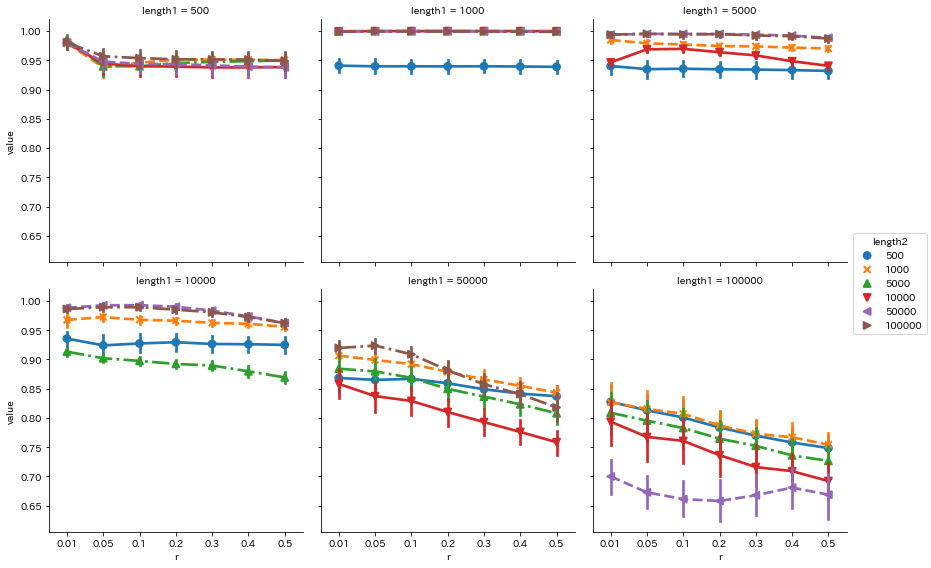

In [29]:
sns.factorplot(x='r', y='value', hue='length2', markers=['o', 'x', '^', 'v', '<', '>'], 
               linestyles=['-', '--', '-.', '-', '--', '-.'], data=results_df_melt, col='length1', col_wrap=3)